# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [210]:
import pandas as pd
import patsy
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v03.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
current_event = 20

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df.fillna(3, inplace=True)

In [9]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground
0,cech,1,1,1,1,13,1,1,50,1,...,3.0,3.0,3.0,3.0,3.0,3,3.000000,3.000000,3.000000,3.0
1,cech,1,2,14,1,6,0,1,50,0,...,3.0,3.0,3.0,3.0,3.0,3,0.681818,3.000000,3.000000,3.0
2,cech,1,3,21,1,19,1,1,50,0,...,8.0,3.0,3.0,3.0,3.0,3,3.750000,0.000000,3.000000,3.0
3,cech,1,4,33,1,5,0,1,50,1,...,11.0,3.0,3.0,6.0,3.0,1,4.493304,0.000000,4.901786,3.0
4,cech,1,5,46,1,15,0,1,50,0,...,49.0,3.0,0.0,2.0,0.0,2,3.663651,5.929855,1.332237,0.0


In [10]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [11]:
last_train_event = 15

In [12]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [13]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [14]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'total_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_var_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_total_points_element_type',
 'roll

In [15]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [16]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [17]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [18]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [19]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [20]:
n_features = X.shape[1]

## Selecting features

In [21]:
estimator = SVR(kernel="linear", C=1, epsilon=1)
selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
F

Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
F

In [209]:
features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
selected_features = pd.Series(features)[selector.support_]
list(selected_features)

['C(element)[T.4]',
 'C(element)[T.6]',
 'C(element)[T.8]',
 'C(element)[T.12]',
 'C(element)[T.13]',
 'C(element)[T.14]',
 'C(element)[T.18]',
 'C(element)[T.23]',
 'C(element)[T.33]',
 'C(element)[T.37]',
 'C(element)[T.39]',
 'C(element)[T.40]',
 'C(element)[T.42]',
 'C(element)[T.43]',
 'C(element)[T.48]',
 'C(element)[T.49]',
 'C(element)[T.50]',
 'C(element)[T.54]',
 'C(element)[T.55]',
 'C(element)[T.56]',
 'C(element)[T.57]',
 'C(element)[T.58]',
 'C(element)[T.60]',
 'C(element)[T.62]',
 'C(element)[T.66]',
 'C(element)[T.69]',
 'C(element)[T.71]',
 'C(element)[T.72]',
 'C(element)[T.73]',
 'C(element)[T.75]',
 'C(element)[T.76]',
 'C(element)[T.77]',
 'C(element)[T.79]',
 'C(element)[T.80]',
 'C(element)[T.82]',
 'C(element)[T.83]',
 'C(element)[T.84]',
 'C(element)[T.85]',
 'C(element)[T.88]',
 'C(element)[T.90]',
 'C(element)[T.91]',
 'C(element)[T.92]',
 'C(element)[T.95]',
 'C(element)[T.98]',
 'C(element)[T.101]',
 'C(element)[T.105]',
 'C(element)[T.110]',
 'C(element)[

In [24]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

### GP tuner

#### Radial basis kernel

In [81]:
rbf_space  = [Real(1.0, 3.0, 'uniform', name='epsilon'),
              Real(1.0, 3.0, 'uniform', name='C'),
              Real(0.010, 0.015, 'uniform', name='gamma'),]

In [82]:
rbf_gp_model = SVR(kernel='rbf')

@use_named_args(rbf_space)
def rbf_objective(**params):
    rbf_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            rbf_gp_model,
            X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [83]:
rbf_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    rbf_res_gp = gp_minimize(rbf_objective, rbf_space, n_calls=50, verbose=2)
    rbf_res_gp_arr.append(rbf_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4372
Function value obtained: 9.8179
Current minimum: 9.8179
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3481
Function value obtained: 9.6531
Current minimum: 9.6531
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0623
Function value obtained: 9.8865
Current minimum: 9.6531
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.9019
Function value obtained: 9.5295
Current minimum: 9.5295
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.0873
Function value obtained: 9.7713
Current minimum: 9.5295
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 4.9986
Function value obtained: 9.4752
Current minimum: 9.4272
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 4.6978
Function value obtained: 9.4362
Current minimum: 9.4272
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 5.0267
Function value obtained: 9.4329
Current minimum: 9.4272
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 3.9531
Function value obtained: 9.4975
Current minimum: 9.4272
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.9698
Function value obtained: 9.4316
Current minimum: 9.4272
Iteration No: 46 started. Sea

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 2.4707
Function value obtained: 9.4297
Current minimum: 9.4297
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 2.7876
Function value obtained: 9.4297
Current minimum: 9.4297
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 2.7345
Function value obtained: 9.4321
Current minimum: 9.4297
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 2.8808
Function value obtained: 9.4292
Current minimum: 9.4292
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 2.9322
Function value obtained: 9.4291
Current minimum: 9.4291
Iteration No: 37 started. Sea

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.4448
Function value obtained: 9.4575
Current minimum: 9.4324
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.7631
Function value obtained: 9.4443
Current minimum: 9.4324
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.8545
Function value obtained: 9.4573
Current minimum: 9.4324
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 4.4578
Function value obtained: 9.4597
Current minimum: 9.4324
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 4.9747
Function value obtained: 9.4351
Current minimum: 9.4324
Iteration No: 28 started. Sea

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 3.7307
Function value obtained: 9.4508
Current minimum: 9.4272
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 3.7946
Function value obtained: 9.4381
Current minimum: 9.4272
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 3.6999
Function value obtained: 9.4522
Current minimum: 9.4272
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 3.3084
Function value obtained: 9.4354
Current minimum: 9.4272
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 4.0331
Function value obtained: 9.4384
Current minimum: 9.4272
Iteration No: 19 started. Sea

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.7684
Function value obtained: 9.8992
Current minimum: 9.4369
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.9468
Function value obtained: 9.5285
Current minimum: 9.4369
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.2812
Function value obtained: 9.4619
Current minimum: 9.4369
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 3.7695
Function value obtained: 9.4390
Current minimum: 9.4369
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 5.6591
Function value obtained: 9.7100
Current minimum: 9.4369
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation d

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.7381
Function value obtained: 9.4316
Current minimum: 9.4256
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 2.6738
Function value obtained: 9.4353
Current minimum: 9.4256
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 2.6875
Function value obtained: 9.4304
Current minimum: 9.4256
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 2.7092
Function value obtained: 9.4304
Current minimum: 9.4256
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 2.7418
Function value obtained: 9.4304
Current minimum: 9.4256
Iteration No: 50 started. Sea

In [84]:
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.427210630206243
9.428961459959444
9.42844339344489
9.426646306697469
9.42559916857673


[2.019218919721449, 1.3751633004164292, 0.015]
[2.0706073059226155, 1.9157581680147326, 0.01]
[2.0312283596704903, 1.566494804751382, 0.013114083331078745]
[2.0573409057936978, 1.564660511729184, 0.012359245024090384]
[2.0067168234092776, 1.406703415012811, 0.01479124305202017]


#### Linear kernel

In [163]:
linear_space  = [Real(1.5, 2.5, 'uniform', name='epsilon'),
                 Real(0.2, 0.4, 'uniform', name='C'),]

In [164]:
linear_gp_model = SVR(kernel='linear')

@use_named_args(linear_space)
def linear_objective(**params):
    linear_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            linear_gp_model,
            X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [166]:
linear_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    linear_res_gp = gp_minimize(linear_objective, linear_space, n_calls=50, verbose=2)
    linear_res_gp_arr.append(linear_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6665
Function value obtained: 9.5256
Current minimum: 9.5256
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3699
Function value obtained: 9.6278
Current minimum: 9.5256
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7237
Function value obtained: 9.5227
Current minimum: 9.5227
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.8386
Function value obtained: 9.6022
Current minimum: 9.5227
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.3648
Function value obtained: 9.6101
Current minimum: 9.5227
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.2211
Function value obtained: 9.4552
Current minimum: 9.4522
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.3565
Function value obtained: 9.4555
Current minimum: 9.4522
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.3794
Function value obtained: 9.4596
Current minimum: 9.4522
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.2746
Function value obtained: 9.4557
Current minimum: 9.4522
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.3877
Function value obtained: 9.4552
Current minimum: 9.4522
Iteration No: 46 started. Sea

In [167]:
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.45216887544982


[2.1481794516740234, 0.2766421516477905]


### Grid search

#### Radial basis kernel

In [85]:
rbf_epsilon = [2.03, 2.05, 2.07]
rbf_C = [1.4, 1.5, 1.6]
rbf_gamma = [0.012, 0.013, 0.014]

rbf_parameters = {
    'epsilon': rbf_epsilon,
    'C': rbf_C,
    'gamma': rbf_gamma
}

In [86]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_rbf.fit(X_sel, y.ravel())

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] C=1.4, epsilon=2.03, gamma=0.012 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=1.4, epsilon=2.03, gamma=0.012, total=   2.3s
[CV] C=1.4, epsilon=2.03, gamma=0.013 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ................. C=1.4, epsilon=2.03, gamma=0.013, total=   2.1s
[CV] C=1.4, epsilon=2.03, gamma=0.014 ................................
[CV] ................. C=1.4, epsilon=2.03, gamma=0.014, total=   2.1s
[CV] C=1.4, epsilon=2.05, gamma=0.012 ................................
[CV] ................. C=1.4, epsilon=2.05, gamma=0.012, total=   2.1s
[CV] C=1.4, epsilon=2.05, gamma=0.013 ................................
[CV] ................. C=1.4, epsilon=2.05, gamma=0.013, total=   2.1s
[CV] C=1.4, epsilon=2.05, gamma=0.014 ................................
[CV] ................. C=1.4, epsilon=2.05, gamma=0.014, total=   2.1s
[CV] C=1.4, epsilon=2.07, gamma=0.012 ................................
[CV] ................. C=1.4, epsilon=2.07, gamma=0.012, total=   2.1s
[CV] C=1.4, epsilon=2.07, gamma=0.013 ................................
[CV] ................. C=1.4, epsilon=2.07, gamma=0.013, total=   2.1s
[CV] C=1.4, epsilon=2.07, gamma=0.014 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   56.8s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [1.4, 1.5, 1.6], 'epsilon': [2.03, 2.05, 2.07],
                         'gamma': [0.012, 0.013, 0.014]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=2)

In [87]:
gs_model_rbf_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon','param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_df

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,1.4,2.03,0.012,-2.224050,-9.432928
1,1.4,2.03,0.013,-2.226680,-9.432331
2,1.4,2.03,0.014,-2.228338,-9.428490
3,1.4,2.05,0.012,-2.229169,-9.430061
4,1.4,2.05,0.013,-2.231577,-9.426833
5,1.4,2.05,0.014,-2.234248,-9.426452
6,1.4,2.07,0.012,-2.234793,-9.425964
7,1.4,2.07,0.013,-2.236852,-9.425090
8,1.4,2.07,0.014,-2.238737,-9.428774
9,1.5,2.03,0.012,-2.225579,-9.432020


In [88]:
gs_model_rbf_df[
    gs_model_rbf_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
15,1.5,2.07,0.012,-2.235703,-9.424814


#### Linear kernel

In [176]:
linear_epsilon = [2.155, 2.16, 2.165]
linear_C = [0.285, 0.29, 0.295]


linear_parameters = {
    'C': linear_C,
    'epsilon': linear_epsilon
}

In [177]:
gs_model_linear = GridSearchCV(
    SVR(kernel='linear'),
    linear_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_linear.fit(X_sel, y.ravel())

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.3s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [0.285, 0.29, 0.295],
                         'epsilon': [2.155, 2.16, 2.165]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [178]:
gs_model_linear_df = pd.DataFrame(gs_model_linear.cv_results_)[[
    'param_C','param_epsilon',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

In [179]:
gs_model_linear_df[
    gs_model_linear_df['split0_test_neg_mean_squared_error'] == \
    gs_model_linear_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
4,0.29,2.16,-2.259276,-9.451098


# Evaluating model

## Radial basis kernel

In [205]:
rbf_model = SVR(kernel='rbf', gamma=0.012, C=1.5, epsilon=2.07)
rbf_model.fit(X_train_sel, y_train.ravel())

SVR(C=1.5, cache_size=200, coef0=0.0, degree=3, epsilon=2.07, gamma=0.012,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [211]:
# get predictions for test set
rbf_y_pred = rbf_model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
rbf_test_loss = (
    mean_absolute_error(y_test, rbf_y_pred),
    mean_squared_error(y_test, rbf_y_pred),
    r2_score(y_test, rbf_y_pred)
)
rbf_test_loss

(2.2357029782599622, 9.424813648119343, 0.09436192805853927)

In [91]:
pd.Series(rbf_y_pred).describe()

count    948.000000
mean       2.835089
std        0.742845
min        1.072145
25%        2.323804
50%        2.821469
75%        3.309436
max        5.112369
dtype: float64

In [93]:
# refit model on all data
rbf_model_full = SVR(kernel='rbf', gamma=0.012, C=1.5, epsilon=2.07)
rbf_model_full.fit(X_sel, y.ravel())

SVR(C=1.5, cache_size=200, coef0=0.0, degree=3, epsilon=2.07, gamma=0.012,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [212]:
# get predictions for whole set
rbf_y_pred_full = rbf_model_full.predict(X_sel).flatten()

# calculate cross entropy loss for test set
rbf_test_loss_full = (
    mean_absolute_error(y, rbf_y_pred_full),
    mean_squared_error(y, rbf_y_pred_full),
    r2_score(y, rbf_y_pred_full)
)
rbf_test_loss_full

(2.1585424319040767, 8.422059163399325, 0.11981931539135682)

In [95]:
pd.Series(rbf_y_pred_full).describe()

count    3644.000000
mean        2.944151
std         0.732338
min         0.919250
25%         2.443727
50%         2.930768
75%         3.429203
max         5.705587
dtype: float64

In [96]:
abs(pd.Series(y.ravel()) - pd.Series(rbf_y_pred_full)).describe()

count    3644.000000
mean        2.158542
std         1.940048
min         0.003621
25%         0.942518
50%         1.748488
75%         2.652479
max        16.039213
dtype: float64

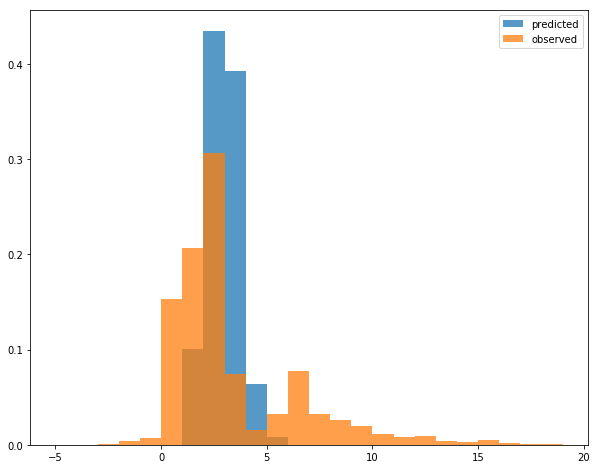

In [195]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

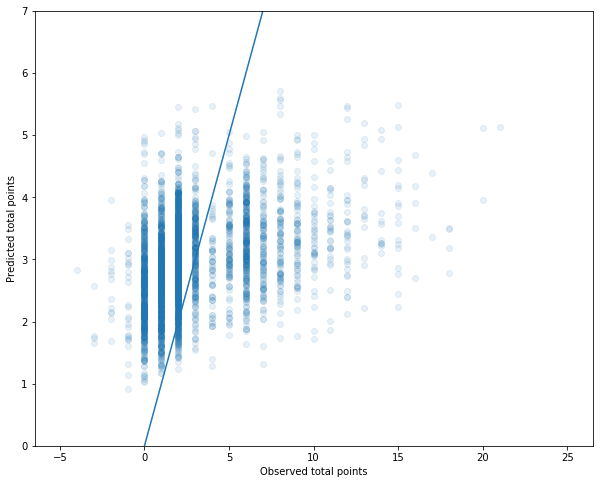

In [197]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(rbf_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

## Linear basis kernel

In [180]:
linear_model = SVR(kernel='linear', C=0.29, epsilon=2.16)
linear_model.fit(X_train_sel, y_train.ravel())

SVR(C=0.29, cache_size=200, coef0=0.0, degree=3, epsilon=2.16,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [213]:
# get predictions for test set
linear_y_pred = linear_model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
linear_test_loss = (
    mean_absolute_error(y_test, linear_y_pred),
    mean_squared_error(y_test, linear_y_pred),
    r2_score(y_test, linear_y_pred)
)
linear_test_loss

(2.2592764278546653, 9.451097737185895, 0.09183626838677272)

In [182]:
pd.Series(linear_y_pred).describe()

count    948.000000
mean       2.902800
std        0.840925
min        0.751019
25%        2.345530
50%        2.867588
75%        3.376924
max        5.816793
dtype: float64

In [183]:
# refit model on all data
linear_model_full = SVR(kernel='linear', C=0.29, epsilon=2.16)
linear_model_full.fit(X_sel, y.ravel())

SVR(C=0.29, cache_size=200, coef0=0.0, degree=3, epsilon=2.16,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [214]:
# get predictions for whole set
linear_y_pred_full = linear_model_full.predict(X_sel).flatten()

# calculate cross entropy loss for test set
linear_test_loss_full = (
    mean_absolute_error(y, linear_y_pred_full),
    mean_squared_error(y, linear_y_pred_full),
    r2_score(y, linear_y_pred_full)
)
linear_test_loss_full

(2.142482220473424, 8.166399367029006, 0.14653805604970516)

In [185]:
pd.Series(linear_y_pred_full).describe()

count    3644.000000
mean        3.009859
std         0.836308
min         0.517142
25%         2.437538
50%         2.974302
75%         3.539229
max         6.313114
dtype: float64

In [186]:
abs(pd.Series(y.ravel()) - pd.Series(linear_y_pred_full)).describe()

count    3644.000000
mean        2.142482
std         1.891336
min         0.000178
25%         0.954680
50%         1.771339
75%         2.596818
max        15.817990
dtype: float64

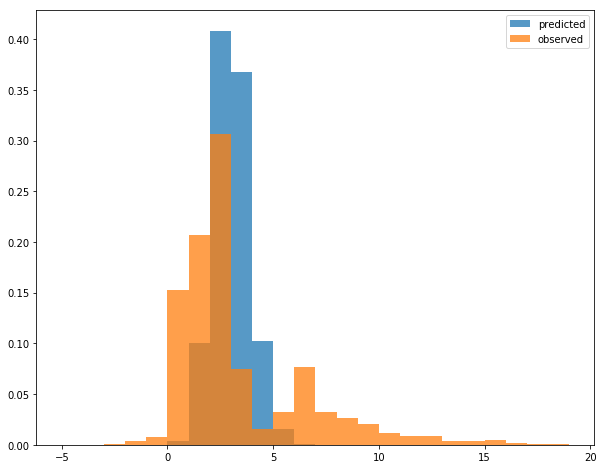

In [189]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(linear_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

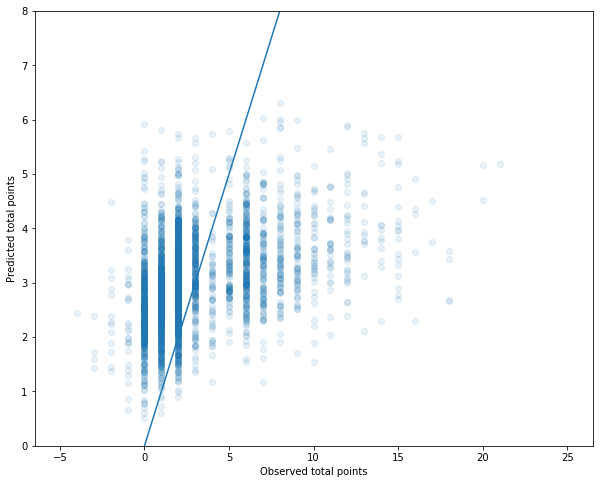

In [194]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(linear_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 8))
plt.show()

## Summary

In [216]:
pd.DataFrame([
    ('Radius basis SVM regression', rbf_test_loss[0], rbf_test_loss[1], rbf_test_loss[2]),
    ('Linear basis SVM regression', linear_test_loss[0], linear_test_loss[1], linear_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Radius basis SVM regression,2.235703,9.424814,0.094362
1,Linear basis SVM regression,2.259276,9.451098,0.091836


In [217]:
pd.DataFrame([
    ('Radius basis SVM regression', rbf_test_loss_full[0], rbf_test_loss_full[1], rbf_test_loss_full[2]),
    ('Linear basis SVM regression', linear_test_loss_full[0], linear_test_loss_full[1], linear_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Radius basis SVM regression,2.158542,8.422059,0.119819
1,Linear basis SVM regression,2.142482,8.166399,0.146538
